In [54]:
import pandas as pd
import numpy as np
import os as os
import acessos as ac
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import datetime
import imgkit

## QUERY

In [55]:

dt_query = "2020-12-01"

In [56]:
query = f"""

with base_aprovados as (
	select 
	dt_mes,
	sum(qtd_contas_total_acum) as qtd_contas_total_acum,
	sum(contas_novas) as contas_novas
	from platform_analytics_zone.monthly_kpis_pag_will 
	group by 1
)
, chats_agg as (
	select 
	dt_chat,
 	max(qtd_contas_total_acum) as qtd_contas_total_acum,
	max(contas_novas) as contas_novas,
  	max(is_holiday) as is_holiday,
	max(is_holiday_or_event) as is_holiday_or_event,
	max(is_eve) as is_eve,
	max(is_post) as is_post,
 	max(case when ds_holiday_or_event = 'Natal' then 1 else 0 end) as flag_natal,
	max(case when ds_holiday_or_event = 'Carnaval' and is_holiday = 1  then 1 else 0 end) as flag_carnaval,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) <= 5 then 1 else 0 end) as flag_5,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 6 and 10 then 1 else 0 end) as flag_6_10,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 11 and 15 then 1 else 0 end) as flag_11_15,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 16 and 20 then 1 else 0 end) as flag_16_20,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 21 and 25 then 1 else 0 end) as flag_21_26,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 26 and 31 then 1 else 0 end) as flag_26_mais,
  	count(distinct id_issue) as chats
	FROM cx_curated_zone.cx_contact_rate c
 	left join base_aprovados a on (a.dt_mes = date_trunc('month', cast(c.dt_chat as date)))
  	left join customer_curated_zone.ca_dict_events e on (e.dt_date = cast(c.dt_chat as date))
	where dt_chat >= to_date('{dt_query}','yyyy-mm-dd')
	and dt_chat < date_add('day', -2, now())
	group by 1
)
, cartao_agg as (
	select 
	dia
	, SUM(ativos_dia) as ativos_dia 
	, SUM(spending_dia) as spending_dia 
	from platform_analytics_zone.daily_spending_pag_will
	where cast(dia as date) >= to_date('{dt_query}','yyyy-mm-dd')
	group by 1
	order by 1
)
select
c.dt_chat
, chats
, qtd_contas_total_acum
, contas_novas
, ativos_dia
, is_holiday
, is_eve
, is_post
, flag_natal
, flag_carnaval
, spending_dia
from chats_agg c
left join cartao_agg ct on (c.dt_chat = cast(ct.dia as date))
order by dt_chat asc


"""

In [57]:
df = ac.df_athena('flavia-costa', query)

In [58]:

df['chats_cliente']  = df['chats'] / df['qtd_contas_total_acum']
df['spending_cliente']  = df['spending_dia'] / df['qtd_contas_total_acum']
df['ativos_cliente']  = df['ativos_dia'] / df['qtd_contas_total_acum']


In [59]:
df['vSPA'] = (((df['spending_cliente'].shift(1) / df['spending_cliente']) - 1) * 100).shift(-1)

In [60]:
df.columns

Index(['dt_chat', 'chats', 'qtd_contas_total_acum', 'contas_novas',
       'ativos_dia', 'is_holiday', 'is_eve', 'is_post', 'flag_natal',
       'flag_carnaval', 'spending_dia', 'chats_cliente', 'spending_cliente',
       'ativos_cliente', 'vSPA'],
      dtype='object')

In [61]:
df.head()

,dt_chat,chats,qtd_contas_total_acum,contas_novas,ativos_dia,is_holiday,is_eve,is_post,flag_natal,flag_carnaval,spending_dia,chats_cliente,spending_cliente,ativos_cliente,vSPA
0,2020-12-01,8538,1462427,48192,102718,0,0,1,0,0,15296292,0.005838,10.459525,0.070238,3.981909
1,2020-12-02,7691,1462427,48192,101991,0,0,1,0,0,14710532,0.005259,10.058986,0.069741,-0.724409
2,2020-12-03,7442,1462427,48192,102247,0,0,0,0,0,14817874,0.005089,10.132385,0.069916,-17.833280
3,2020-12-04,9708,1462427,48192,117320,0,0,0,0,0,18033912,0.006638,12.331496,0.080223,-2.342497
4,2020-12-05,4518,1462427,48192,124574,0,0,0,0,0,18466489,0.003089,12.627289,0.085183,105.297630


In [62]:
df[['dt_chat','chats','spending_cliente' , 'vSPA']]

,dt_chat,chats,spending_cliente,vSPA
0,2020-12-01,8538,10.459525,3.981909
1,2020-12-02,7691,10.058986,-0.724409
2,2020-12-03,7442,10.132385,-17.833280
3,2020-12-04,9708,12.331496,-2.342497
4,2020-12-05,4518,12.627289,105.297630
...,...,...,...,...
946,2023-07-05,29350,15.037703,1.619699
947,2023-07-06,28407,14.798019,-1.213306
948,2023-07-07,25382,14.979770,7.013912
949,2023-07-08,16563,13.997965,46.968763


## Join df final

In [63]:
df['dt_chat'] = pd.to_datetime(df['dt_chat'])

In [64]:
print(len(df))
df = df[df['vSPA'].notnull()]
print(len(df))

951
950


In [65]:
df['ano'] = df['dt_chat'].map(lambda x: x.strftime('%Y'))
df['dia'] = df['dt_chat'].map(lambda x: x.strftime('%d'))
df['mes'] = df['dt_chat'].map(lambda x: x.strftime('%m'))
df['dia_semana'] = df['dt_chat'].map(lambda x: x.strftime('%A'))


## Transformações para modelagem

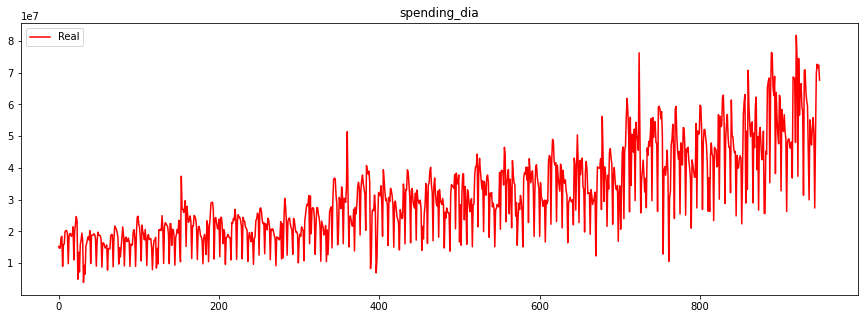

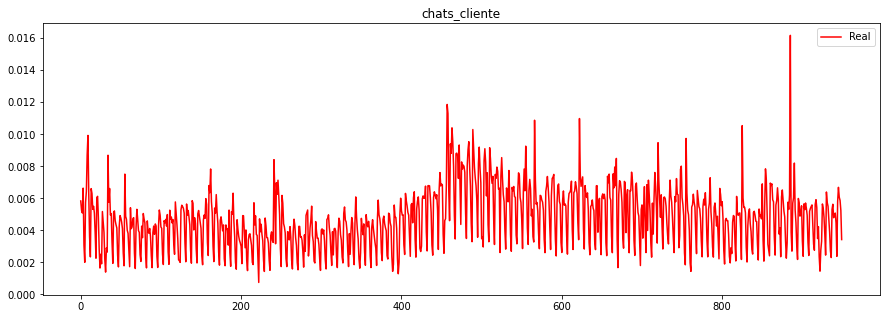

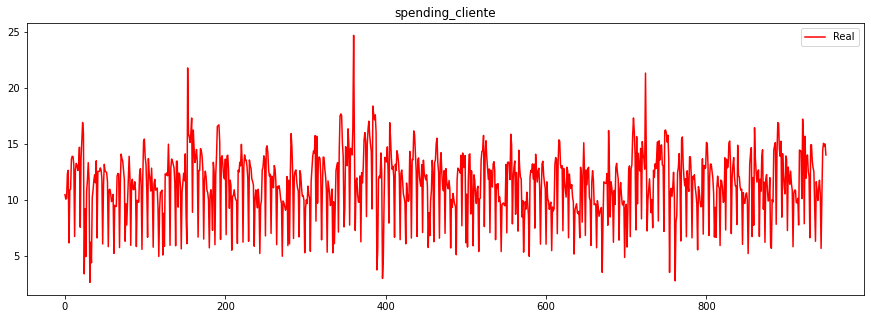

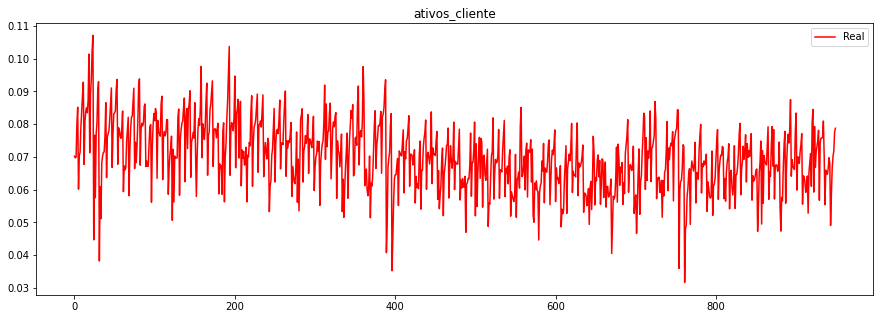

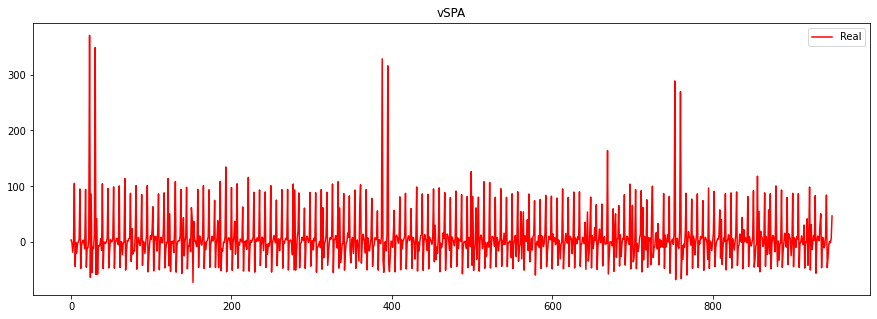

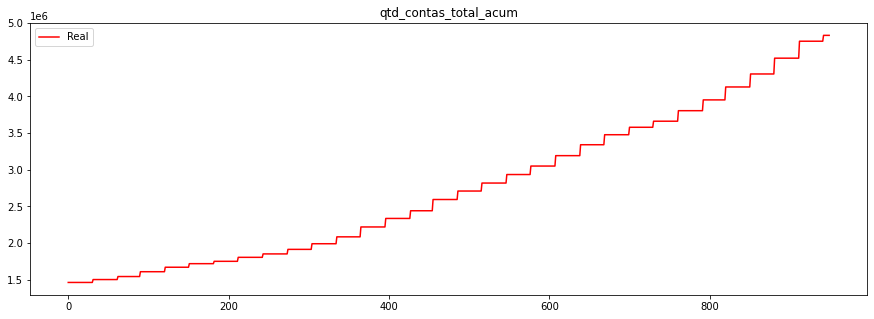

In [66]:
graficos = ['spending_dia', 'chats_cliente', 'spending_cliente',
       'ativos_cliente', 'vSPA', 'qtd_contas_total_acum']

for i in graficos:
  plt.figure(figsize=(15,5))
  plt.plot(df[i], color = 'red', label = 'Real')
  plt.legend()
  plt.title(i)

In [67]:
df[graficos].corr(method='pearson')

,spending_dia,chats_cliente,spending_cliente,ativos_cliente,vSPA,qtd_contas_total_acum
spending_dia,1.000000,0.433502,0.563965,0.105221,0.224423,0.807909
chats_cliente,0.433502,1.000000,0.487597,0.026620,-0.032238,0.195101
spending_cliente,0.563965,0.487597,1.000000,0.713080,0.436221,0.013254
ativos_cliente,0.105221,0.026620,0.713080,1.000000,0.595385,-0.359223
vSPA,0.224423,-0.032238,0.436221,0.595385,1.000000,-0.019600
qtd_contas_total_acum,0.807909,0.195101,0.013254,-0.359223,-0.019600,1.000000


In [68]:
df['ln_vSPA'] = np.log(df.vSPA)
df['ln_chats_cliente'] = np.log(df.chats_cliente)
df['ln_ativos_cliente'] = np.log(df.ativos_cliente)
df['ln_qtd_contas_total_acum'] = np.log(df.qtd_contas_total_acum)

/home/flavia.costa/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [116]:
formula_text = """
ln_vSPA ~
+ C(ano) +C(dia) +C(mes) +C(dia_semana) +is_holiday +is_eve +flag_natal +flag_carnaval+ is_post+
ln_ativos_cliente + 
ln_chats_cliente +
ln_qtd_contas_total_acum

"""
model = ols(formula = formula_text, data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ln_vSPA   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     18.36
Date:                Tue, 11 Jul 2023   Prob (F-statistic):           2.19e-87
Time:                        11:05:40   Log-Likelihood:                -676.35
No. Observations:                 519   AIC:                             1471.
Df Residuals:                     460   BIC:                             1722.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      9.8995     35.623      0.278      0.781     -60.105      79.904
C(ano)[T.2021]                 0.2230      1.122      0.199      0.843      -1.982       2.428
C(ano)[T.2022]                 1.3039      2.392      0.545      0.586      -3.397       6.005
C(ano)[T.2023]                 0.9540      3.576      0.267      0.790      -6.074       7.982
C(dia)[T.02]                  -1.2732      0.353     -3.604      0.000      -1.967      -0.579
C(dia)[T.03]                  -0.5071      0.443     -1.146      0.253      -1.377       0.363
C(dia)[T.04]                  -0.6046      0.370     -1.633      0.103      -1.332       0.123
C(dia)[T.05]                  -1.4195      0.314     -4.526      0.000      -2.036      -0.803
C(dia)[T.06]                  -0.2312      0.335     -0.689      0.491      -0.890       0.428
C(dia)[T.07]                  -0.8959      0.342     -2.621      0.009      -1.568      -0.224
C(dia)[T.08]                  -1.1985      0.464     -2.585      0.010      -2.110      -0.287
C(dia)[T.09]                  -1.1861      0.380     -3.121      0.002      -1.933      -0.439
C(dia)[T.10]                  -0.7090      0.341     -2.077      0.038      -1.380      -0.038
C(dia)[T.11]                  -0.6135      0.333     -1.844      0.066      -1.267       0.040
C(dia)[T.12]                  -0.7137      0.350     -2.040      0.042      -1.401      -0.026
C(dia)[T.13]                  -1.4078      0.432     -3.256      0.001      -2.257      -0.558
C(dia)[T.14]                  -1.5628      0.380     -4.109      0.000      -2.310      -0.815
C(dia)[T.15]                  -0.4841      0.336     -1.441      0.150      -1.144       0.176
C(dia)[T.16]                  -0.8698      0.314     -2.772      0.006      -1.486      -0.253
C(dia)[T.17]                  -0.8317      0.312     -2.670      0.008      -1.444      -0.219
C(dia)[T.18]                  -1.3436      0.496     -2.708      0.007      -2.319      -0.369
C(dia)[T.19]                  -1.5134      0.387     -3.914      0.000      -2.273      -0.753
C(dia)[T.20]                  -0.9229      0.357     -2.585      0.010      -1.625      -0.221
C(dia)[T.21]                  -1.0581      0.365     -2.898      0.004      -1.775      -0.341
C(dia)[T.22]                  -1.3890      0.349     -3.983      0.000      -2.074      -0.704
C(dia)[T.23]                  -1.0927      0.330     -3.311      0.001      -1.741      -0.444
C(dia)[T.24]                  -1.3100      0.463     -2.831      0.005      -2.220      -0.401
C(dia)[T.25]                  -0.5340      0.338     -1.581      0.115      -1.198       0.130
C(dia)[T.26]                  -0.5179      0.321     -1.614      0.107      -1.148       0.113
C(dia)[T.27]                  -0.6342      

Text(0.5, 1.0, 'Previsão de série temporal')

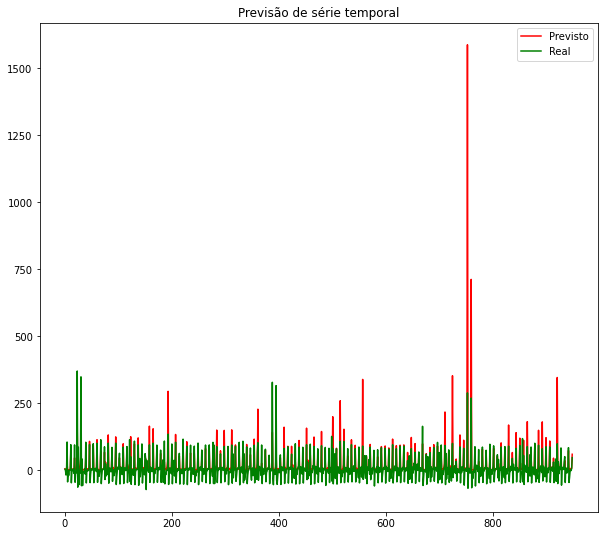

In [159]:
Ypred = np.array(np.exp(model.predict(df)))
Yreal = np.array(df['vSPA'])

plt.figure(figsize=(10,9))
plt.plot(Ypred, color = 'red', label = 'Previsto')
plt.plot(Yreal, color = 'green', label = 'Real')
plt.legend()
plt.title('Previsão de série temporal')

In [160]:
mape = np.mean(np.abs((Yreal - Ypred) / Yreal)) * 100
print(mape)

364.9436753745967


In [161]:
mape_med = np.median(np.abs((Yreal - Ypred) / Yreal)) * 100
print(mape_med)

102.17712637277315


In [117]:
df_sim = df[['spending_dia', 'ano', 'dia', 'mes', 'dia_semana', 'is_holiday', 'is_eve', 'flag_natal', 'flag_carnaval', 'is_post', 'ln_ativos_cliente', 
'ln_qtd_contas_total_acum', 'qtd_contas_total_acum']]

In [118]:
df_sim['chats_cliente'] = df['chats_cliente'] * (1 - 0.10)

df[['chats_cliente']]

/tmp/ipykernel_2084201/3600863839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim['chats_cliente'] = df['chats_cliente'] * (1 - 0.10)


,chats_cliente
0,0.005838
1,0.005259
2,0.005089
3,0.006638
4,0.003089
...,...
945,0.006688
946,0.006071
947,0.005876
948,0.005251


In [109]:
df_sim[['chats_cliente']]

,chats_cliente
0,0.005254
1,0.004733
2,0.004580
3,0.005974
4,0.002780
...,...
945,0.006020
946,0.005464
947,0.005289
948,0.004725


In [119]:
df_sim['ln_chats_cliente'] = np.log(df_sim['chats_cliente'])

/tmp/ipykernel_2084201/681139464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim['ln_chats_cliente'] = np.log(df_sim['chats_cliente'])


In [120]:
var_sim = model.predict(df_sim)

In [154]:
var_sim

0      1.731862
1      0.686148
2      0.589518
3      1.228764
4      3.255442
         ...   
945    1.365454
946    1.082990
947    2.093926
948    2.143364
949    4.171976
Length: 950, dtype: float64

In [121]:
df_sim['vSPA_sim'] = np.exp(var_sim)

/tmp/ipykernel_2084201/1268333015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim['vSPA_sim'] = np.exp(var_sim)


In [122]:
df_sim['vSPA_sim']

0       5.651167
1       1.986051
2       1.803119
3       3.417005
4      25.931083
         ...    
945     3.917501
946     2.953498
947     8.116718
948     8.528081
949    64.843451
Name: vSPA_sim, Length: 950, dtype: float64

In [132]:
df_sim.vSPA_sim.describe()

count     950.000000
mean       22.357309
std        74.404615
min         0.147118
25%         2.700753
50%         4.875941
75%         9.381603
max      1726.351232
Name: vSPA_sim, dtype: float64

In [144]:
#meta_cr = -0.1
#df['var_resposta'] = meta_cr * -0.7975
#df['vSPA_sim'] = df.vSPA * (df.var_resposta + 1)

df_sim['vSPA_sim'] = np.where(df_sim['vSPA_sim'] > 4.87, 4.87, df_sim['vSPA_sim'])
df['spending_cliente_sim'] = (df['spending_clieplt.figure(figsize=(25,9))
plt.plot(Ypred, color = 'red', label = 'Real')
plt.plot(Yreal, color = 'blue', label = 'Previsto')
plt.legend()
plt.title('Previsão de série temporal')nte'].shift(-1) * (1 + (df_sim.vSPA_sim/100))).shift(1)
df['spending_dia_sim'] = df.spending_cliente_sim * df.qtd_contas_total_acum
    

/tmp/ipykernel_2084201/3251372474.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim['vSPA_sim'] = np.where(df_sim['vSPA_sim'] > 4.87, 4.87, df_sim['vSPA_sim'])


<AxesSubplot:ylabel='vSPA_sim'>

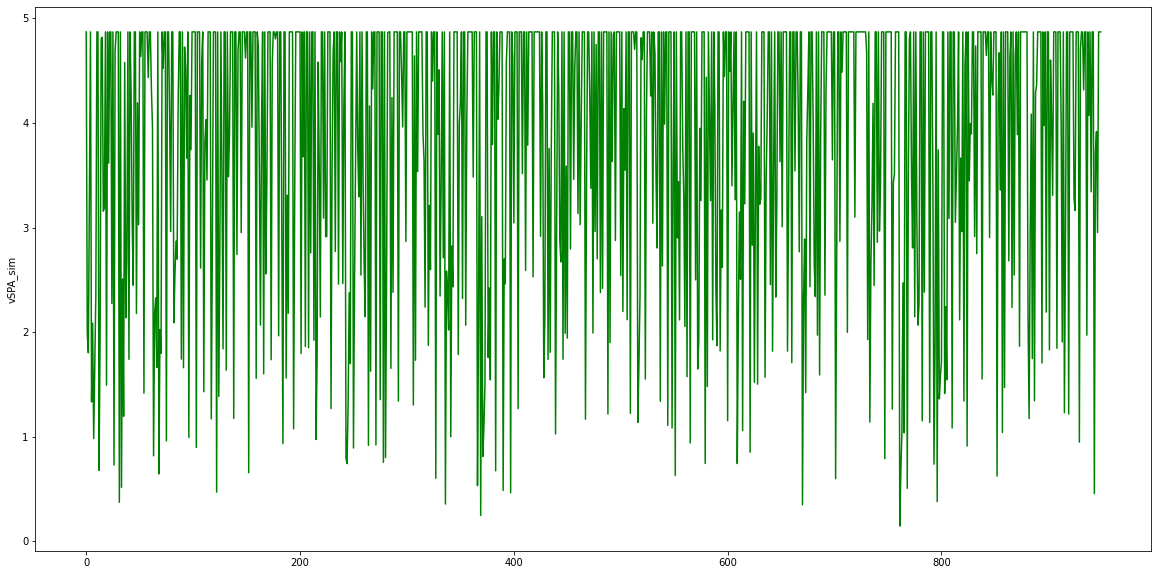

In [153]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df_sim.vSPA_sim, color="g")


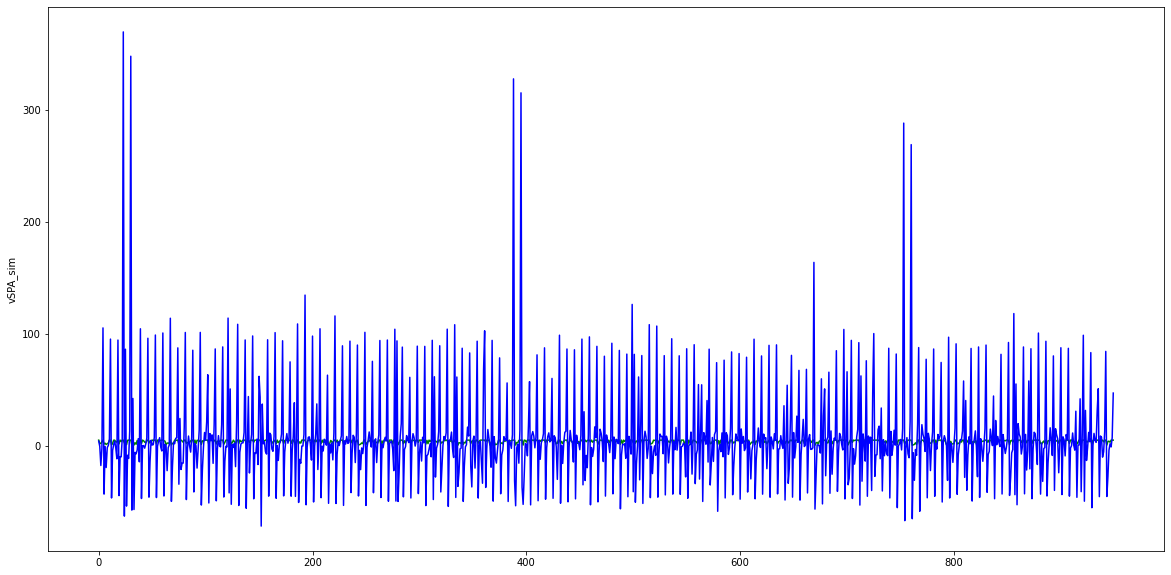

In [145]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df_sim.vSPA_sim, color="g")
sns.lineplot(data=df.vSPA, color="b")
plt.show()

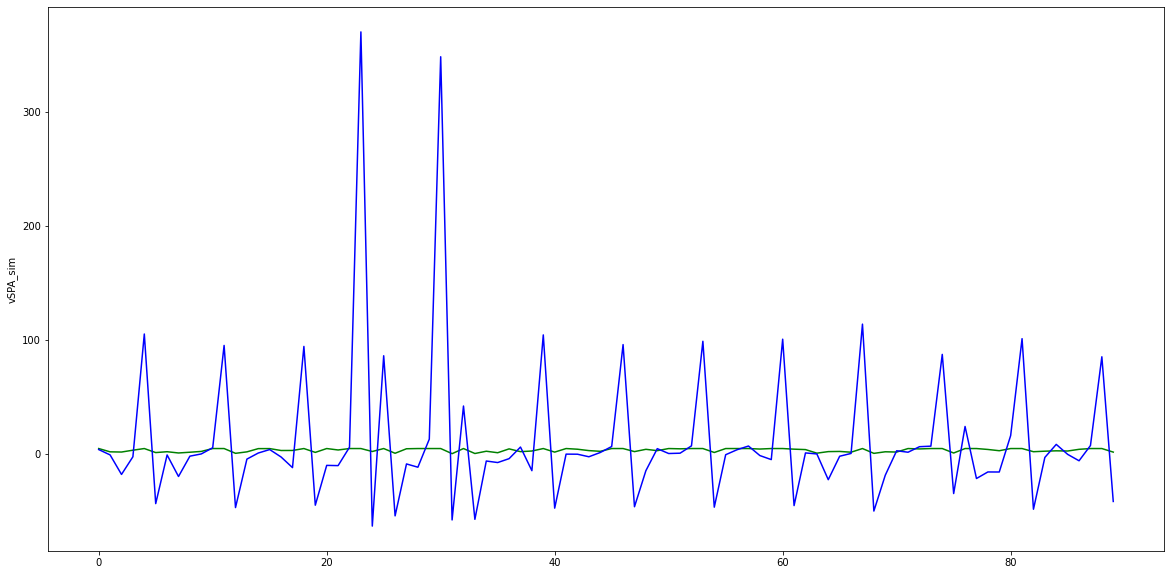

In [146]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df_sim.vSPA_sim[:90], color="g")
sns.lineplot(data=df.vSPA[:90], color="b")
plt.show()

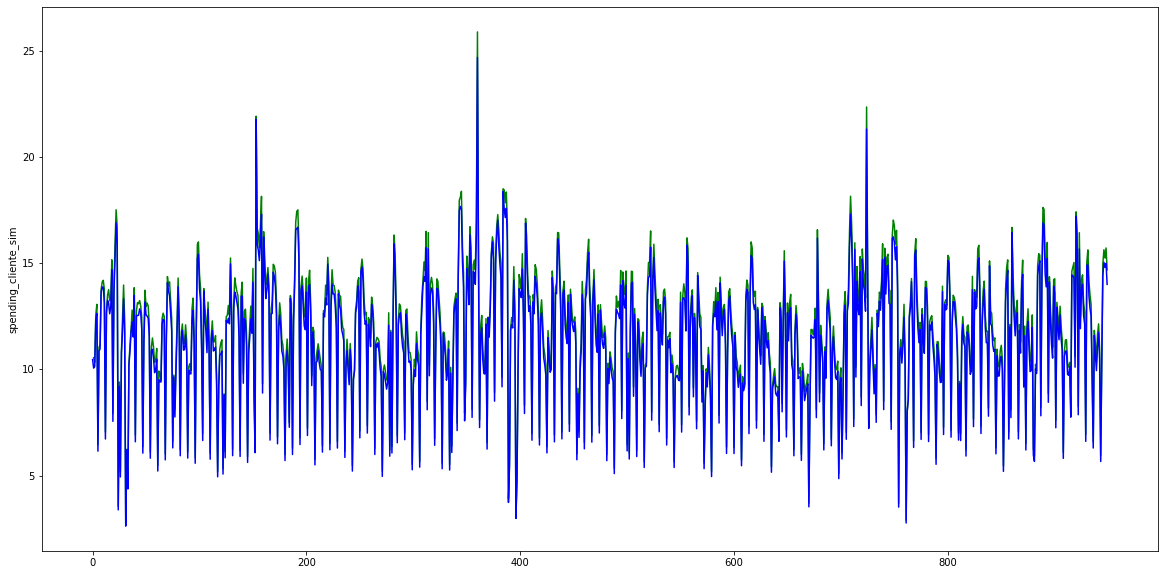

In [147]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df.spending_cliente_sim, color="g")
sns.lineplot(data=df.spending_cliente, color="b")
plt.show()

<AxesSubplot:ylabel='spending_dia_sim'>

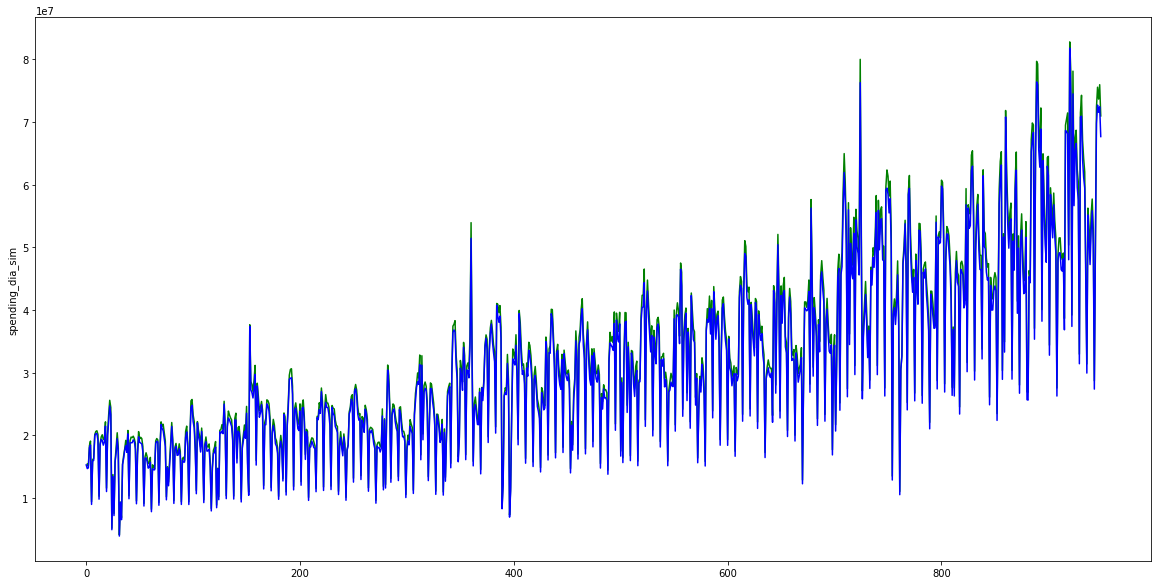

In [148]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df.spending_dia_sim, color="g")
sns.lineplot(data=df.spending_dia, color="b")

<AxesSubplot:ylabel='chats'>

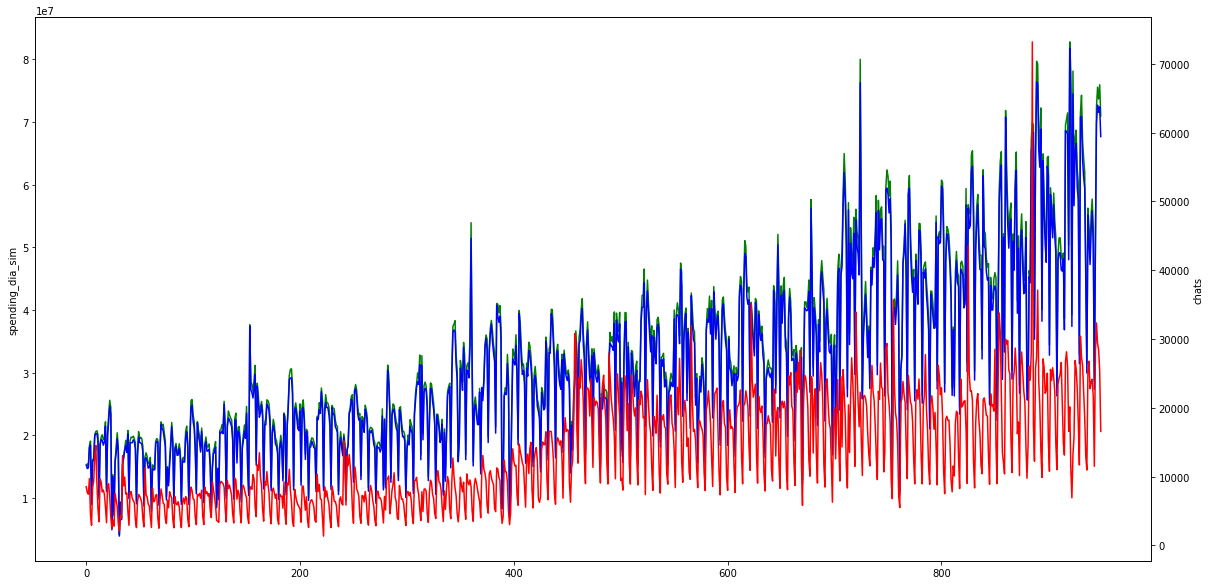

In [149]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df.spending_dia_sim, color="g")
sns.lineplot(data=df.spending_dia, color="b")
ax3 = plt.twinx()
sns.lineplot(data=df.chats, color="r", ax=ax3)

In [150]:
df['impacto'] = df.spending_dia_sim - df.spending_dia

<AxesSubplot:ylabel='chats'>

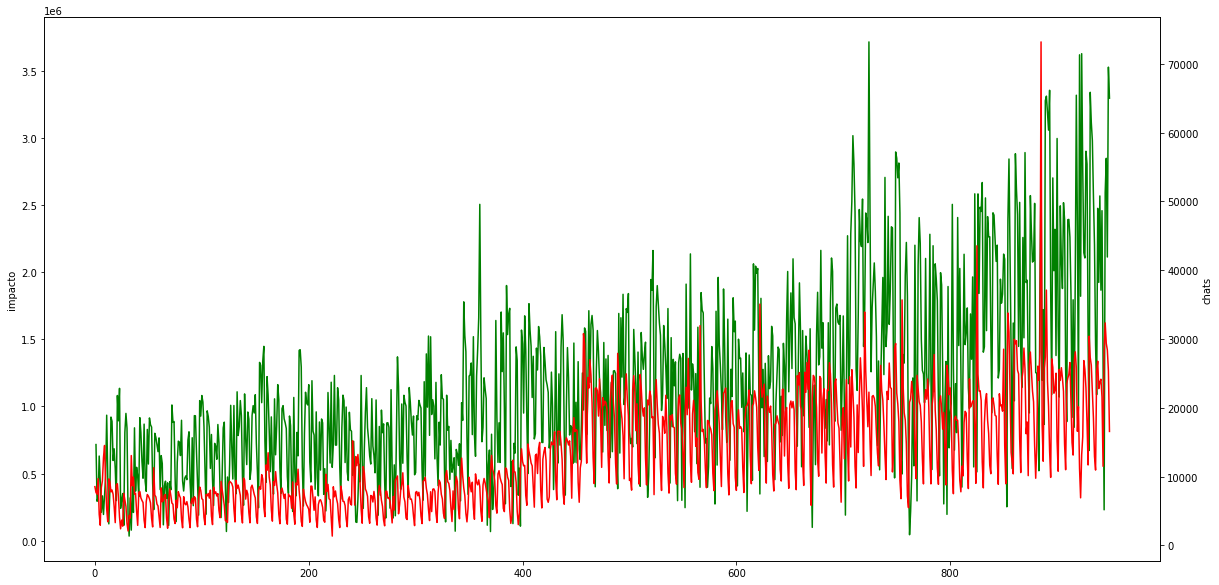

In [151]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df.impacto, color="g")
ax3 = plt.twinx()
sns.lineplot(data=df.chats, color="r", ax=ax3)

In [152]:
df.groupby(['ano', 'mes']).agg({'spending_dia_sim':['sum'], 'spending_dia':['sum'], 'impacto':['sum']})

spending_dia_sim spending_dia       impacto
                      sum          sum           sum
ano  mes                                            
2020 12      5.255189e+08    524288971  1.652622e+07
2021 01      4.947625e+08    477703700  1.705881e+07
     02      4.755055e+08    460435701  1.506977e+07
     03      5.631864e+08    542762185  2.042421e+07
     04      5.795476e+08    558128979  2.141867e+07
     05      6.942081e+08    668513956  2.569411e+07
     06      6.406742e+08    617511372  2.316283e+07
     07      6.529320e+08    629633464  2.329858e+07
     08      6.476848e+08    627940900  1.974390e+07
     09      6.254442e+08    602273107  2.317110e+07
     10      7.240491e+08    697450740  2.659831e+07
     11      8.537912e+08    823271564  3.051964e+07
     12      9.185108e+08    890438714  2.807211e+07
2022 01      8.640410e+08    829424722  3.461625e+07
     02      8.254221e+08    798407113  2.701499e+07
     03      9.323823e+08    896873914  3.550839e+07
     04      9.256309e+08    890144804  3.548609e+07
     05      1.019277e+09    981573361  3.770328e+07
     06      1.001749e+09    968368890  3.338046e+07
     07      1.045789e+09   1009025144  3.676420e+07
     08      1.129597e+09   1092940964  3.665560e+07
     09      1.058136e+09   1018437013  3.969910e+07
     10      1.143224e+09   1102718441  4.050568e+07
     11      1.390351e+09   1331531989  5.881916e+07
     12      1.440453e+09   1386964247  5.348884e+07
2023 01      1.331333e+09   1290631026  4.070228e+07
     02      1.257388e+09   1220842846  3.654540e+07
     03      1.512069e+09   1453613626  5.845587e+07
     04      1.475882e+09   1420465182  5.541730e+07
     05      1.735262e+09   1672554234  6.270753e+07
     06      1.765107e+09   1699267574  6.583989e+07
     07      5.006724e+08    482272667  1.839976e+07